In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import DivergingNorm
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.manifold import TSNE
from statsmodels.stats.multitest import multipletests
import scipy.stats as stats
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns


# Read in Raw Data

In [2]:
df_metabolite = pd.read_csv("../raw/metabolon_data_v2.csv")
df_metabolite.drop(columns=["Sample"],inplace=True)
df_metabolite.head()

,Group,100002945,100002356,100009062,100020727,100003926,100009271,100006374,100008903,100009217,...,100002913,100001394,100001451,566,100003640,100003641,100003210,1004,100000299,100000015
0,EH_WT,1.5959,2.2525,0.5193,0.1545,0.1332,0.5575,2.2126,0.9842,0.8874,...,0.3347,0.7943,2.9738,0.9425,3.8285,1.7171,0.7939,2.1062,4.6456,2.9835
1,EH_WT,0.4808,0.3736,0.2941,0.1545,0.2002,0.4725,0.5041,1.0077,0.9708,...,0.2876,1.7898,4.0980,0.8634,2.2947,2.3060,1.3240,1.1835,3.7010,1.8032
2,EH_WT,0.6393,0.6153,0.2941,0.1545,0.2416,0.5666,0.2683,1.2829,1.6096,...,0.2243,0.2880,1.0257,0.6015,1.1362,1.0880,0.9940,0.9168,1.2714,1.2557
3,EH_WT,0.7445,0.7167,0.2941,0.1545,0.3067,0.6158,1.0000,0.6810,0.4618,...,1.5555,1.5633,1.5438,0.8071,0.7525,0.7213,1.3981,1.0934,1.5455,0.8756
4,EH_WT,0.3496,0.2635,0.2941,0.1545,0.4728,0.7166,0.2683,0.9937,0.6315,...,0.7055,0.9881,1.0104,0.4416,1.0011,0.9842,0.6383,0.9799,1.8851,0.7286


In [3]:
# split into features and sample IDs
df_metab_features = df_metabolite.drop(columns=["Group"])
df_metab_group = df_metabolite.Group
df_metab_features.head()

,100002945,100002356,100009062,100020727,100003926,100009271,100006374,100008903,100009217,100000657,...,100002913,100001394,100001451,566,100003640,100003641,100003210,1004,100000299,100000015
0,1.5959,2.2525,0.5193,0.1545,0.1332,0.5575,2.2126,0.9842,0.8874,1.1921,...,0.3347,0.7943,2.9738,0.9425,3.8285,1.7171,0.7939,2.1062,4.6456,2.9835
1,0.4808,0.3736,0.2941,0.1545,0.2002,0.4725,0.5041,1.0077,0.9708,0.8836,...,0.2876,1.7898,4.0980,0.8634,2.2947,2.3060,1.3240,1.1835,3.7010,1.8032
2,0.6393,0.6153,0.2941,0.1545,0.2416,0.5666,0.2683,1.2829,1.6096,0.9985,...,0.2243,0.2880,1.0257,0.6015,1.1362,1.0880,0.9940,0.9168,1.2714,1.2557
3,0.7445,0.7167,0.2941,0.1545,0.3067,0.6158,1.0000,0.6810,0.4618,0.9524,...,1.5555,1.5633,1.5438,0.8071,0.7525,0.7213,1.3981,1.0934,1.5455,0.8756
4,0.3496,0.2635,0.2941,0.1545,0.4728,0.7166,0.2683,0.9937,0.6315,0.6931,...,0.7055,0.9881,1.0104,0.4416,1.0011,0.9842,0.6383,0.9799,1.8851,0.7286


In [4]:
# print out the unique experimental groups
print(np.unique(df_metab_group))

df_metab_group.head()

['EH_WT' 'ES_KO' 'ES_WT' 'LH_WT' 'LS_WT']


0    EH_WT
1    EH_WT
2    EH_WT
3    EH_WT
4    EH_WT
Name: Group, dtype: object

In [5]:
# create dictionary to convert chemical IDs in header to metabolite name/info
# make chemical ID as string, so both BIOCHEMICAL and CHEMICAL ID are strings
df_chemIDs = pd.read_csv("../raw/metabolite_definitions.csv")
df_chemIDs.head()

,PATHWAY SORTORDER,BIOCHEMICAL,SUPER PATHWAY,SUB PATHWAY,COMP ID,PLATFORM,CHEMICAL ID,RI,MASS,HMDB,PUBCHEM
0,1642,(14 or 15)-methylpalmitate (a17:0 or i17:0),Lipid,"Fatty Acid, Branched",38768,LC/MS Neg,100002945,5695.0,269.2487,HMDB0061859,8181;17903417
1,1648,(16 or 17)-methylstearate (a19:0 or i19:0),Lipid,"Fatty Acid, Branched",38296,LC/MS Neg,100002356,5993.0,297.2799,HMDB0037397,3083779
2,4283,(3'-5')-adenylylcytidine,Nucleotide,Dinucleotide,52753,LC/MS Neg,100009062,1920.0,571.1308,NaN,10875494
3,4288,(3'-5')-cytidylylcytidine*,Nucleotide,Dinucleotide,62397,LC/MS Neg,100020727,1472.0,547.1195,NaN,94237
4,1919,(R)-3-hydroxybutyrylcarnitine,Lipid,"Fatty Acid Metabolism (Acyl Carnitine, Hydroxy)",43264,LC/MS Pos Early,100003926,2400.0,248.1493,HMDB0013127,53481617


In [6]:
dict_chemID_to_metabolite = pd.Series(df_chemIDs["BIOCHEMICAL"].values, 
                                      index=df_chemIDs['CHEMICAL ID'].apply(str)).to_dict()
dict_chemID_to_compID = pd.Series(df_chemIDs["COMP ID"].values, 
                                      index=df_chemIDs['CHEMICAL ID'].apply(str)).to_dict()
dict_chemID_to_subPathway = pd.Series(df_chemIDs["SUB PATHWAY"].values, 
                                      index=df_chemIDs['CHEMICAL ID'].apply(str)).to_dict()
dict_chemID_to_HMDB = pd.Series(df_chemIDs["HMDB"].values, 
                                      index=df_chemIDs['CHEMICAL ID'].apply(str)).to_dict()
dict_chemID_to_pubchem = pd.Series(df_chemIDs["PUBCHEM"].values, 
                                      index=df_chemIDs['CHEMICAL ID'].apply(str)).to_dict()

# test dictionary

print(dict_chemID_to_metabolite["100002945"])
print(dict_chemID_to_compID["100002945"])
print(dict_chemID_to_subPathway["100002945"])
print(dict_chemID_to_HMDB["100002945"])
print(dict_chemID_to_pubchem["100002945"])

(14 or 15)-methylpalmitate (a17:0 or i17:0)
38768
Fatty Acid, Branched
HMDB0061859
8181;17903417


## Visualize Metabolon's PCA data

In [9]:
# read in PCA data by Metabolon
df_PCA = pd.read_csv('../raw/metabolon_PCAdata_v2.csv')
# pool the genotypes
df_PCA.Group = df_PCA.Group.str.replace("KO","WT")
print(np.unique(df_PCA.Group))
df_PCA.Group = df_PCA.Group.str.replace("EH_WT","NS (Early)")
df_PCA.Group = df_PCA.Group.str.replace("ES_WT","S (Early)")
df_PCA.Group = df_PCA.Group.str.replace("LH_WT","NS (Late)")
df_PCA.Group = df_PCA.Group.str.replace("LS_WT","S (Late)")
print(np.unique(df_PCA.Group))
df_PCA.head()

['EH_WT' 'ES_WT' 'LH_WT' 'LS_WT']
['NS (Early)' 'NS (Late)' 'S (Early)' 'S (Late)']


,parent_sample_name,Comp.1 [32.27%],Comp.2 [10.49%],Comp.3 [6.29%],Group,CLIENT_IDENTIFIER,PARAM_AGE,PARAM_ANIMAL_ID,PARAM_CLIENT_SAMPLE_ID,PARAM_GENDER,PARAM_GROUP_ID
0,HARV-24507,17.5260,5.8146,10.4833,NS (Early),EH1,10w,11.15.18 #2,Early healthy WT,F,EH_WT
1,HARV-24508,20.8321,3.2770,-0.5978,NS (Early),EH3,10w,11.15.18 #4,Early healthy WT,F,EH_WT
2,HARV-24509,18.3319,-5.2940,-15.3460,NS (Early),EH5,8w,12.7.18 #7,Early healthy WT,M,EH_WT
3,HARV-24510,15.9809,8.6459,0.4178,NS (Early),EH7,8w,12.7.18 #11,Early healthy WT,F,EH_WT
4,HARV-24511,21.9713,-9.8173,-12.7455,NS (Early),EH9,6w,2.1.19 #6,Early healthy WT,M,EH_WT


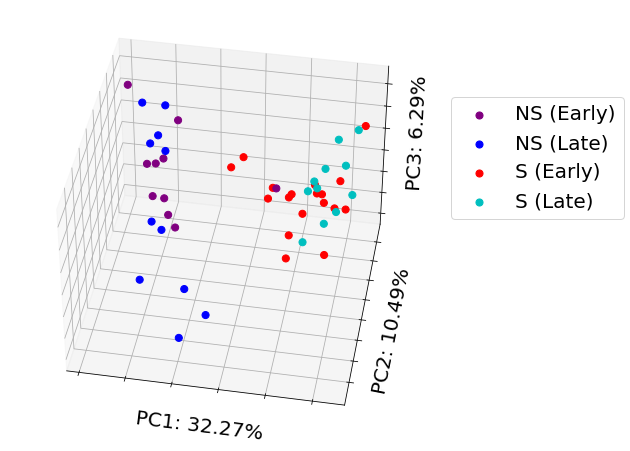

In [35]:
# plot 3D PCA
# define colormap
n = len(np.unique(df_PCA.Group))
color=iter(plt.cm.rainbow(np.linspace(0,1,n)))
color = ['purple','b','r','c']

fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
for i in range(n):
    #c = next(color)
    c = color[i]
    group = np.unique(df_PCA.Group)[i]
    idx = np.where(df_PCA.Group == group)[0]
    ax.scatter(df_PCA.iloc[idx,1],
                df_PCA.iloc[idx,2],
                df_PCA.iloc[idx,3],
                c=c, label=group, alpha = 1,
              s=50)

ax.set_xlabel('PC1: 32.27%',fontsize=20)
ax.set_ylabel('PC2: 10.49%',fontsize=20)
ax.set_zlabel('PC3: 6.29%',fontsize=20)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
lgd=ax.legend(loc='right',bbox_to_anchor=(1.45,0.65),
                   fontsize=20)
# plt.title('PCA of all Timepoints')
ax.view_init(40,100)
plt.savefig('../processed/metabolon_pooledGeno_3dPCA.png', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

# Characterize mice

## Begin by scaling

In [10]:
scaler = StandardScaler() 
robust_df_metab = scaler.fit_transform(df_metabolite.iloc[:,1:]) 
robust_df_metab = pd.DataFrame(data=robust_df_metab, columns = df_metabolite.iloc[:,1:].columns)
print(robust_df_metab.shape)
robust_df_metab.head()


(48, 917)


,100002945,100002356,100009062,100020727,100003926,100009271,100006374,100008903,100009217,100000657,...,100002913,100001394,100001451,566,100003640,100003641,100003210,1004,100000299,100000015
0,0.955047,1.029150,-0.105178,-0.680542,-1.174854,-0.874329,2.762015,-0.102636,-0.481975,0.796738,...,-0.327552,-0.282423,1.851996,-0.216845,4.584446,1.145048,-0.750062,3.627018,2.753674,3.062633
1,-1.051473,-0.781529,-0.576796,-0.680542,-1.080393,-0.968137,-0.125356,-0.014989,-0.378046,-0.534605,...,-0.361046,0.630519,3.052432,-0.420642,2.008821,2.359321,0.494083,0.395180,1.921346,1.205416
2,-0.766267,-0.548605,-0.576796,-0.680542,-1.022025,-0.864286,-0.523859,1.011418,0.417995,-0.038750,...,-0.406061,-0.746734,-0.228212,-1.095413,0.063416,-0.152115,-0.280427,-0.538961,-0.219480,0.343917
3,-0.576969,-0.450887,-0.576796,-0.680542,-0.930243,-0.809988,0.712717,-1.233473,-1.012336,-0.237696,...,0.540598,0.422803,0.325022,-0.565696,-0.580910,-0.908226,0.667996,0.079596,0.022041,-0.254175
4,-1.287556,-0.887632,-0.576796,-0.680542,-0.696064,-0.698744,-0.523859,-0.067204,-0.800865,-1.356715,...,-0.063864,-0.104695,-0.244549,-1.507386,-0.163450,-0.366144,-1.115256,-0.317947,0.321278,-0.485481


## compute similarity matrix among samples

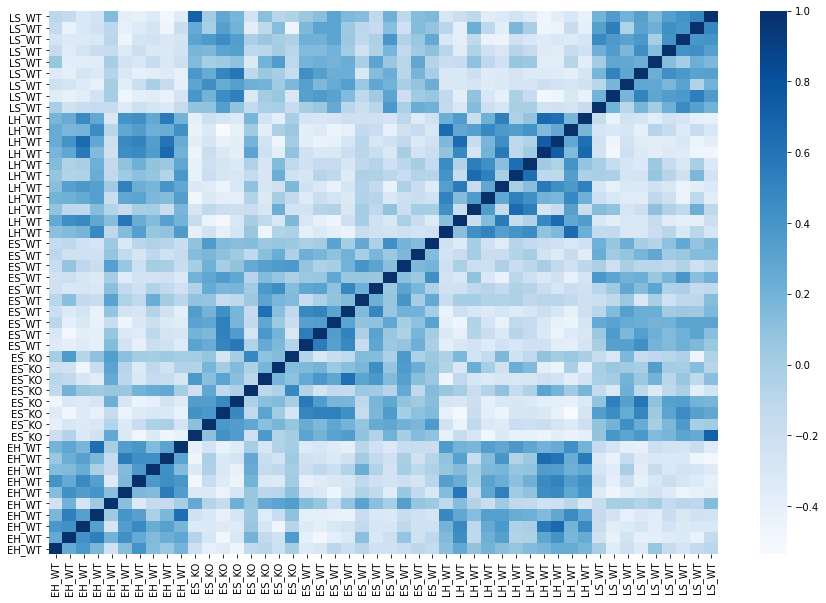

In [11]:
# first sort the dataframe as per the mouse groups.
# get alphabetical indexing
sort_idx = np.argsort(np.array(df_metabolite.iloc[:,0]))
robust_df_metab = robust_df_metab.iloc[sort_idx]

similarity_mat = cosine_similarity(robust_df_metab)
plt.figure(figsize=(15,10))
ax = sns.heatmap(similarity_mat,cmap='Blues', 
                 xticklabels=df_metab_group.iloc[sort_idx], yticklabels=df_metab_group.iloc[sort_idx])
ax.invert_yaxis()
plt.savefig('../processed/similarity_matrix.png')
plt.show()

In [17]:
# Now, convinced there are no meaningful differences between KO and WT, let's pool the genotypes together. replace KO with WT.
df_metab_PooledGeno=df_metabolite
df_metab_PooledGeno.Group=df_metab_PooledGeno.Group.str.replace("KO","WT")
df_metab_PooledGeno.Group = df_metab_PooledGeno.Group.str.replace("EH_WT","NS (Early)")
df_metab_PooledGeno.Group = df_metab_PooledGeno.Group.str.replace("ES_WT","S (Early)")
df_metab_PooledGeno.Group = df_metab_PooledGeno.Group.str.replace("LH_WT","NS (Late)")
df_metab_PooledGeno.Group = df_metab_PooledGeno.Group.str.replace("LS_WT","S (Late)")
df_metab_PooledGeno.head(20)
sort_idx = np.argsort(np.array(df_metab_PooledGeno.Group))

# remake robust df
robust_df_metab_2 = scaler.fit_transform(df_metab_PooledGeno.iloc[:,1:]) 
robust_df_metab_2 = pd.DataFrame(data=robust_df_metab_2, columns = df_metab_PooledGeno.iloc[:,1:].columns)
robust_df_metab_2 = robust_df_metab_2.iloc[sort_idx]

# # update original metab features, group with new sort index
# df_metab_features_PooledGeno = df_metab_features.iloc[sort_idx]
# df_metab_group_PooledGeno = df_metab_group_PooledGeno.iloc[sort_idx]
df_metab_PooledGeno = df_metab_PooledGeno.iloc[sort_idx]

In [19]:
df_metab_PooledGeno.head(20)

,Group,100002945,100002356,100009062,100020727,100003926,100009271,100006374,100008903,100009217,...,100002913,100001394,100001451,566,100003640,100003641,100003210,1004,100000299,100000015
0,NS (Early),1.5959,2.2525,0.5193,0.1545,0.1332,0.5575,2.2126,0.9842,0.8874,...,0.3347,0.7943,2.9738,0.9425,3.8285,1.7171,0.7939,2.1062,4.6456,2.9835
25,NS (Early),0.9679,0.8708,0.2941,0.1545,0.2848,0.7368,2.6701,0.9065,0.5806,...,1.0860,5.5642,4.5280,0.8334,0.9989,1.2538,0.9898,0.9497,5.2619,2.5829
26,NS (Early),1.8438,1.7089,0.2941,0.1545,0.4492,0.6439,1.3949,0.8406,0.4726,...,0.9140,1.6819,2.2484,0.6352,0.4710,0.4317,0.4937,0.6316,0.9094,1.2494
28,NS (Early),1.4099,0.7476,0.2941,0.1545,0.1819,0.6014,0.2683,0.6453,0.3528,...,0.8052,1.5476,0.5610,0.3831,1.3134,0.7177,0.6965,0.9174,2.4652,0.3365
5,NS (Early),1.5550,1.9403,0.2941,0.1545,1.1211,1.1007,0.2683,0.6933,0.9205,...,0.0683,0.8733,0.8915,0.6896,0.5123,0.6470,0.9666,0.8868,0.5241,0.6401
27,NS (Early),0.9551,0.8439,0.2941,0.1545,0.3269,0.5304,1.6923,0.5998,0.3218,...,1.6467,3.2031,1.6746,0.7160,0.5911,0.9900,2.0629,0.6058,0.9689,1.0000
3,NS (Early),0.7445,0.7167,0.2941,0.1545,0.3067,0.6158,1.0000,0.6810,0.4618,...,1.5555,1.5633,1.5438,0.8071,0.7525,0.7213,1.3981,1.0934,1.5455,0.8756
2,NS (Early),0.6393,0.6153,0.2941,0.1545,0.2416,0.5666,0.2683,1.2829,1.6096,...,0.2243,0.2880,1.0257,0.6015,1.1362,1.0880,0.9940,0.9168,1.2714,1.2557
1,NS (Early),0.4808,0.3736,0.2941,0.1545,0.2002,0.4725,0.5041,1.0077,0.9708,...,0.2876,1.7898,4.0980,0.8634,2.2947,2.3060,1.3240,1.1835,3.7010,1.8032
4,NS (Early),0.3496,0.2635,0.2941,0.1545,0.4728,0.7166,0.2683,0.9937,0.6315,...,0.7055,0.9881,1.0104,0.4416,1.0011,0.9842,0.6383,0.9799,1.8851,0.7286


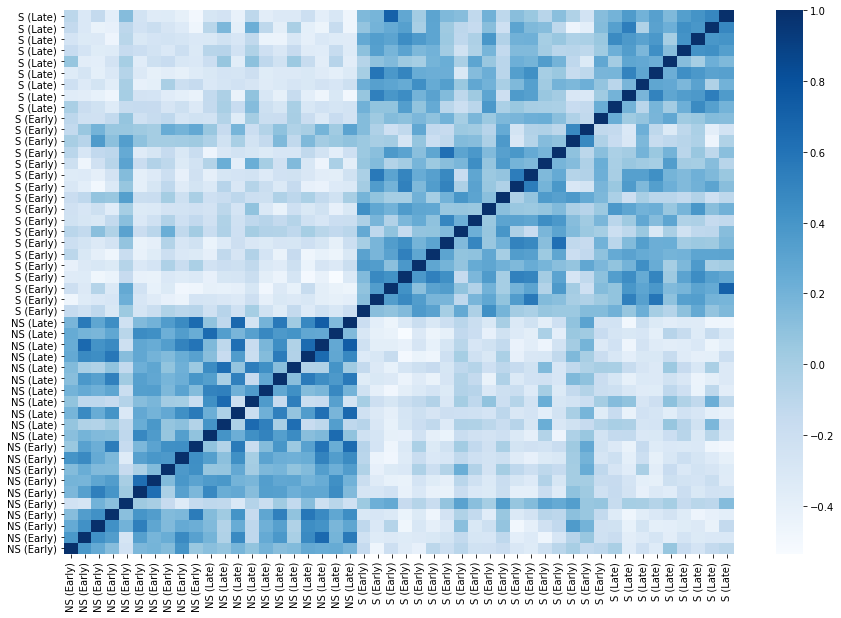

In [21]:
similarity_mat = cosine_similarity(robust_df_metab_2)
plt.figure(figsize=(15,10))
ax = sns.heatmap(similarity_mat,cmap='Blues', 
                 xticklabels=df_metab_PooledGeno.Group,
                 yticklabels=df_metab_PooledGeno.Group)
ax.invert_yaxis()
plt.savefig('../processed/similarity_matrix_pooledGeno.png')
plt.show()

## Generate heatmap with hierarchical clustering

In [23]:
import matplotlib.patches as mpatches

lut = dict(zip(df_metab_PooledGeno.Group.unique(), ["b","r","purple","c"]))
row_colors = df_metab_PooledGeno.Group.map(lut)
vmin = -2
vmax = 2
cmap1=sns.diverging_palette(240, 10, n=100)

handle1=mpatches.Patch(color='b', label=df_metab_PooledGeno.Group.unique()[0])
handle2=mpatches.Patch(color='r', label=df_metab_PooledGeno.Group.unique()[1])
handle3=mpatches.Patch(color='purple', label=df_metab_PooledGeno.Group.unique()[2])
handle4=mpatches.Patch(color='c', label=df_metab_PooledGeno.Group.unique()[3])


C:\Users\Aditya\anaconda3\lib\site-packages\seaborn\matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 432x288 with 0 Axes>

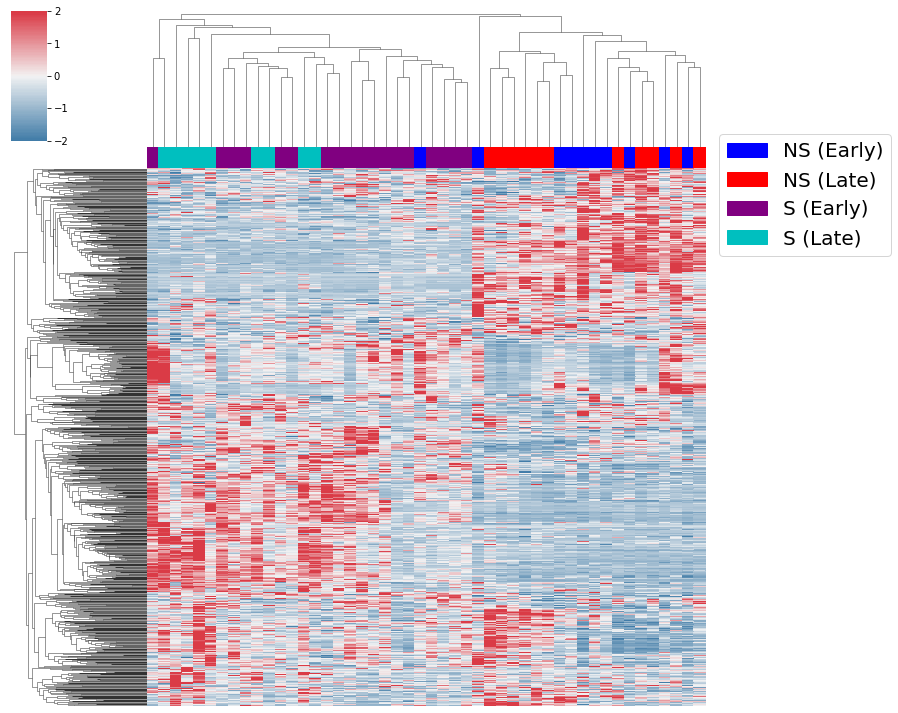

In [24]:
plt.figure()
g = sns.clustermap(StandardScaler().fit_transform(df_metab_PooledGeno.iloc[:,1:]).T, 
                   col_cluster=True,col_colors=list(row_colors),
                   cmap=cmap1,vmin=vmin,vmax=vmax,center=0,
                  xticklabels=False,
                   yticklabels=False)
lgd = g.ax_heatmap.legend(handles=[handle1,handle2,handle3,handle4], loc='right',bbox_to_anchor=(1.35,0.95),
                   fontsize=20)
plt.savefig('../processed/metabolite_heatmap.png', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

# Begin Scaling and Dimensionality Reduction

## Begin for all data points

In [16]:
df_metabolite_PooledGeno = df_metabolite.copy()
df_metabolite_PooledGeno.Group = df_metabolite_PooledGeno.Group.str.replace("KO","WT")
print(np.unique(df_metabolite_PooledGeno.Group))

# split into features and sample IDs
df_metab_features_PooledGeno = df_metabolite_PooledGeno.drop(columns=["Group"])
df_metab_group_PooledGeno = df_metabolite_PooledGeno.Group


['EH_WT' 'ES_WT' 'LH_WT' 'LS_WT']


In [17]:
# Make pipelines
pipeline_1 = make_pipeline(RobustScaler(), PCA())
pipeline_2 = make_pipeline(RobustScaler(), TSNE(n_components=3, random_state=42))

# PCA
df_metab_features_pca = pipeline_1.fit(df_metab_features_PooledGeno)
print(df_metab_features_pca[1].components_.shape) # num_components, num_features

# tSNE
df_metab_features_tSNE = pipeline_2.fit(df_metab_features_PooledGeno)
print(df_metab_features_tSNE[1].embedding_.shape) # num_samples, num_components

# transform dim reduction onto feature matrix
# output is num_samples x num_components
df_features_pca_transf = pd.DataFrame(df_metab_features_pca[1].transform(df_metab_features_PooledGeno))
print(df_features_pca_transf.shape)

df_features_tSNE_transf = pd.DataFrame(df_metab_features_tSNE[1].fit_transform(df_metab_features_PooledGeno))
print(df_features_tSNE_transf.shape)

(48, 917)
(48, 3)
(48, 48)
(48, 3)


In [18]:
def plot_DimRed(df_pca_transf, df_tSNE_transf, df_groupNames,
                pca_pipeline, tSNE_pipeline,
                fn_out_explVar, fn_out_PCA2D, fn_out_PCA3D,
               fn_out_tSNE2D, fn_out_tSNE3D):
    # plot explained variance
    plt.figure()
    expl_var_array = np.cumsum(pca_pipeline[1].explained_variance_ratio_)
    plt.plot(expl_var_array)
    plt.ylabel('Fraction of Variance Explained')
    plt.xlabel('# of Components')
    plt.savefig(fn_out_explVar)
    plt.show()


    ###########################################################################################
    ## plot PCA
    # define colormap
    n = len(np.unique(df_groupNames))
    color=iter(plt.cm.rainbow(np.linspace(0,1,n)))

    # plot 2D
    plt.figure()
    for i in range(n):
        c = next(color)
        group = np.unique(df_groupNames)[i]
        idx = np.where(df_groupNames == group)[0]
        plt.scatter(df_pca_transf.loc[idx,0],
                    df_pca_transf.iloc[idx,1],
                   c=c, label=group, alpha = 0.7)

    plt.ylabel('PC2: {}'.format(round(expl_var_array[1]-expl_var_array[0],3)))
    plt.xlabel('PC1: {}'.format(round(expl_var_array[0],3)))
    plt.xticks([])
    plt.yticks([])
    plt.legend()
    plt.title('PCA of all Timepoints')
    plt.savefig(fn_out_PCA2D)
    plt.show()

    # plot 3D PCA
    # define colormap
    n = len(np.unique(df_groupNames))
    color=iter(plt.cm.rainbow(np.linspace(0,1,n)))

    fig = plt.figure()
    ax = Axes3D(fig)
    for i in range(n):
        c = next(color)
        group = np.unique(df_groupNames)[i]
        idx = np.where(df_groupNames == group)[0]
        ax.scatter(df_pca_transf.loc[idx,0],
                    df_pca_transf.iloc[idx,1],
                   df_pca_transf.iloc[idx,2],
                   c=c, label=group)

    ax.set_xlabel('PC1: {}'.format(round(expl_var_array[0],3)))
    ax.set_ylabel('PC2: {}'.format(round(expl_var_array[1]-expl_var_array[0],3)))
    ax.set_zlabel('PC3: {}'.format(round(expl_var_array[2]-expl_var_array[1]-expl_var_array[0],3)))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    plt.legend()
    plt.title('PCA of all Timepoints')
    plt.savefig(fn_out_PCA3D)
    plt.show()

    ###########################################################################################
    ## plot tSNE
    # define colormap
    n = len(np.unique(df_groupNames))
    color=iter(plt.cm.rainbow(np.linspace(0,1,n)))

    # plot 2D
    plt.figure()
    for i in range(n):
        c = next(color)
        group = np.unique(df_groupNames)[i]
        idx = np.where(df_groupNames == group)[0]
        plt.scatter(df_tSNE_transf.iloc[idx,0],
                    df_tSNE_transf.iloc[idx,1],
                   c=c, label=group, alpha = 0.7)

    plt.xlabel('tSNE1')
    plt.ylabel('tSNE2')
    plt.xticks([])
    plt.yticks([])
    plt.legend()
    plt.title('tSNE of all Timepoints')
    plt.savefig(fn_out_tSNE2D)
    plt.show()

    # plot 3D PCA
    # define colormap
    n = len(np.unique(df_groupNames))
    color=iter(plt.cm.rainbow(np.linspace(0,1,n)))

    fig = plt.figure()
    ax = Axes3D(fig)
    for i in range(n):
        print(i)
        c = next(color)
        group = np.unique(df_groupNames)[i]
        idx = np.where(df_groupNames == group)[0]
        ax.scatter(df_tSNE_transf.iloc[idx,0],
                    df_tSNE_transf.iloc[idx,1],
                   df_tSNE_transf.iloc[idx,2],
                   c=c, label=group)

    ax.set_xlabel('tSNE1')
    ax.set_ylabel('tSNE2')
    ax.set_zlabel('tSNE3')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    plt.legend()
    plt.title('tSNE of all Timepoints')
    plt.savefig(fn_out_tSNE3D)
    plt.show()

In [19]:
df_metab_group_PooledGeno

0     EH_WT
1     EH_WT
2     EH_WT
3     EH_WT
4     EH_WT
5     EH_WT
6     ES_WT
7     ES_WT
8     ES_WT
9     ES_WT
10    ES_WT
11    ES_WT
12    ES_WT
13    ES_WT
14    ES_WT
15    LH_WT
16    LH_WT
17    LH_WT
18    LH_WT
19    LH_WT
20    LS_WT
21    LS_WT
22    LS_WT
23    LS_WT
24    LS_WT
25    EH_WT
26    EH_WT
27    EH_WT
28    EH_WT
29    ES_WT
30    ES_WT
31    ES_WT
32    ES_WT
33    ES_WT
34    ES_WT
35    ES_WT
36    ES_WT
37    ES_WT
38    LH_WT
39    LH_WT
40    LH_WT
41    LH_WT
42    LH_WT
43    LH_WT
44    LS_WT
45    LS_WT
46    LS_WT
47    LS_WT
Name: Group, dtype: object

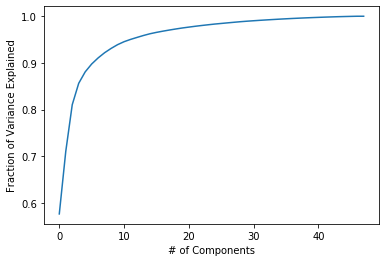

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

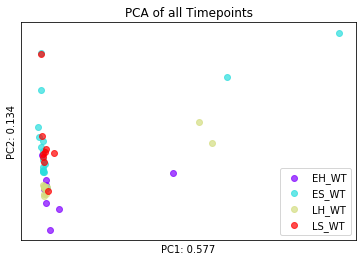

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

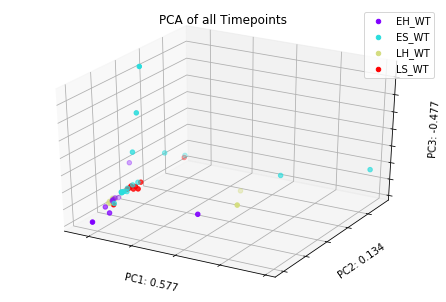

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

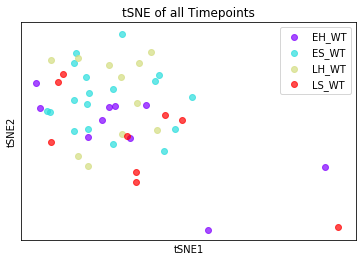

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

0
1
2
3


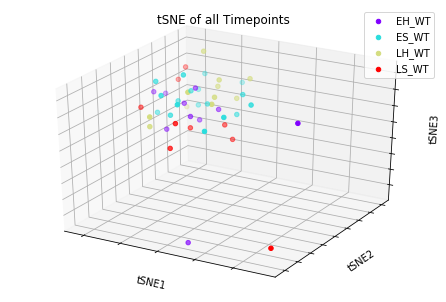

In [20]:
plot_DimRed(df_features_pca_transf, df_features_tSNE_transf, df_metab_group_PooledGeno,
            df_metab_features_pca, df_metab_features_tSNE,
            '../processed/plot_PoolGeno_explVar_1.png', 
            '../processed/plot_PoolGeno_PCA_1.png',
            '../processed/plot_PoolGeno_PCA_2.png',
            '../processed/plot_PoolGeno_tSNE_1.png',
            '../processed/plot_PoolGeno_tSNE_2.png')

# Perform Statistical Tests and volcano plots

In [33]:
# reset index
df_metab_PooledGeno = df_metab_PooledGeno.reset_index(drop=True)
df_metab_PooledGeno.head(20)

,Group,100002945,100002356,100009062,100020727,100003926,100009271,100006374,100008903,100009217,...,100002913,100001394,100001451,566,100003640,100003641,100003210,1004,100000299,100000015
0,NS (Early),1.5959,2.2525,0.5193,0.1545,0.1332,0.5575,2.2126,0.9842,0.8874,...,0.3347,0.7943,2.9738,0.9425,3.8285,1.7171,0.7939,2.1062,4.6456,2.9835
1,NS (Early),0.9679,0.8708,0.2941,0.1545,0.2848,0.7368,2.6701,0.9065,0.5806,...,1.0860,5.5642,4.5280,0.8334,0.9989,1.2538,0.9898,0.9497,5.2619,2.5829
2,NS (Early),1.8438,1.7089,0.2941,0.1545,0.4492,0.6439,1.3949,0.8406,0.4726,...,0.9140,1.6819,2.2484,0.6352,0.4710,0.4317,0.4937,0.6316,0.9094,1.2494
3,NS (Early),1.4099,0.7476,0.2941,0.1545,0.1819,0.6014,0.2683,0.6453,0.3528,...,0.8052,1.5476,0.5610,0.3831,1.3134,0.7177,0.6965,0.9174,2.4652,0.3365
4,NS (Early),1.5550,1.9403,0.2941,0.1545,1.1211,1.1007,0.2683,0.6933,0.9205,...,0.0683,0.8733,0.8915,0.6896,0.5123,0.6470,0.9666,0.8868,0.5241,0.6401
5,NS (Early),0.9551,0.8439,0.2941,0.1545,0.3269,0.5304,1.6923,0.5998,0.3218,...,1.6467,3.2031,1.6746,0.7160,0.5911,0.9900,2.0629,0.6058,0.9689,1.0000
6,NS (Early),0.7445,0.7167,0.2941,0.1545,0.3067,0.6158,1.0000,0.6810,0.4618,...,1.5555,1.5633,1.5438,0.8071,0.7525,0.7213,1.3981,1.0934,1.5455,0.8756
7,NS (Early),0.6393,0.6153,0.2941,0.1545,0.2416,0.5666,0.2683,1.2829,1.6096,...,0.2243,0.2880,1.0257,0.6015,1.1362,1.0880,0.9940,0.9168,1.2714,1.2557
8,NS (Early),0.4808,0.3736,0.2941,0.1545,0.2002,0.4725,0.5041,1.0077,0.9708,...,0.2876,1.7898,4.0980,0.8634,2.2947,2.3060,1.3240,1.1835,3.7010,1.8032
9,NS (Early),0.3496,0.2635,0.2941,0.1545,0.4728,0.7166,0.2683,0.9937,0.6315,...,0.7055,0.9881,1.0104,0.4416,1.0011,0.9842,0.6383,0.9799,1.8851,0.7286


[('NS (Early)', 'S (Early)'), ('NS (Early)', 'S (Late)'), ('NS (Late)', 'S (Early)'), ('NS (Late)', 'S (Late)'), ('NS (Late)', 'NS (Early)')]
(10, 917)
(917,)
(917,)
(917,)
(917,)
(917,)
(917,)
(917,)
917
(917, 13)
       Metab       LFC        pvalue         p_adj    mean1     mean2  \
0        803 -2.721875  2.848404e-10  8.024164e-08  5.04979  0.765433   
1        482 -2.137304  1.861687e-10  8.024164e-08  3.43370  0.780494   
2        572 -2.626641  3.522740e-10  8.024164e-08  4.58805  0.742900   
3  100005864 -1.375394  1.769963e-10  8.024164e-08  1.97381  0.760800   
4  100019968 -1.622718  4.375226e-10  8.024164e-08  2.12020  0.688478   

       std1      std2       SNR                             Metabolite  \
0  1.728862  0.305124 -2.106385                                mannose   
1  1.007349  0.286037 -2.051363                                lactate   
2  1.526462  0.383902 -2.012784                                glucose   
3  0.440097  0.163346 -2.010146  methyl glucopyran

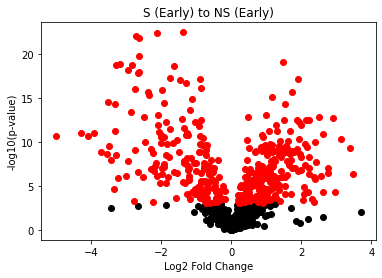

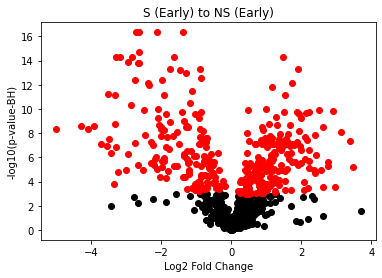

(10, 917)
(917,)
(917,)
(917,)
(917,)
(917,)
(917,)
(917,)
917
(917, 13)
       Metab       LFC        pvalue         p_adj    mean1     mean2  \
0  100001300  3.046777  8.036133e-11  7.369134e-08  0.30722  2.538756   
1  100001541  3.693703  1.800743e-09  8.256405e-07  0.13760  1.780467   
2  100002284  3.723556  1.480646e-08  2.556430e-06  0.24365  3.218611   
3        192  2.439038  1.019662e-08  2.556430e-06  0.38827  2.105511   
4  100001143  2.316720  1.672692e-08  2.556430e-06  0.46903  2.336700   

       std1      std2       SNR                  Metabolite  \
0  0.136598  0.450222  3.802757    alpha-hydroxyisovalerate   
1  0.073037  0.418432  3.342767  2-hydroxy-3-methylvalerate   
2  0.229492  0.853551  2.746854     2S,3R-dihydroxybutyrate   
3  0.195481  0.454785  2.640827          N-acetylputrescine   
4  0.237444  0.502761  2.523180           3-hydroxysuberate   

                                  SubPathway         HMDB PubchemID  
0  Leucine, Isoleucine and Valine Metab

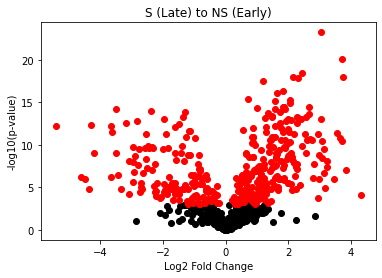

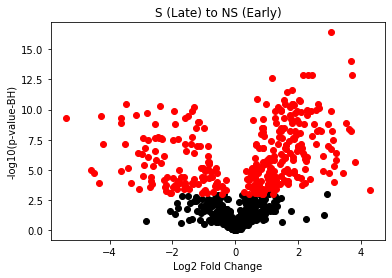

(11, 917)
(917,)
(917,)
(917,)
(917,)
(917,)
(917,)
(917,)
917
(917, 13)
       Metab       LFC        pvalue         p_adj     mean1     mean2  \
0        482 -2.180737  1.982354e-15  1.817819e-12  3.538645  0.780494   
1        363 -1.216969  3.219376e-14  1.476084e-11  1.718418  0.739239   
2        811 -1.728066  6.513256e-14  1.990885e-11  2.568864  0.775428   
3  100020419 -2.105476  1.958061e-13  4.488855e-11  2.819155  0.655100   
4  100004555 -1.979347  3.014325e-11  4.606893e-09  1.145527  0.290511   

       std1      std2       SNR                   Metabolite  \
0  0.593431  0.286037 -3.136156                      lactate   
1  0.246849  0.099261 -2.829098                 myo-inositol   
2  0.443303  0.217854 -2.712572                      alanine   
3  0.539077  0.300159 -2.578600  1-carboxyethylphenylalanine   
4  0.321207  0.043338 -2.345432            benzoylcarnitine*   

                                          SubPathway         HMDB PubchemID  
0  Glycolysis, Gluc

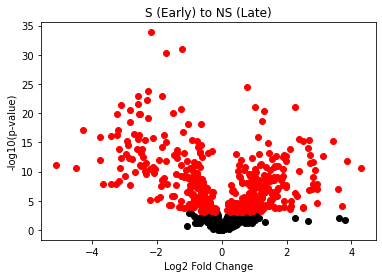

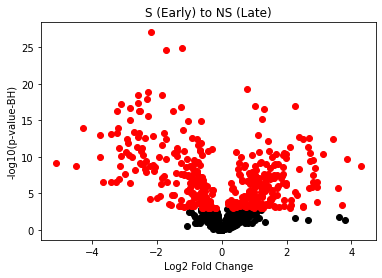

(11, 917)
(917,)
(917,)
(917,)
(917,)
(917,)
(917,)
(917,)
917
(917, 13)
       Metab       LFC        pvalue         p_adj     mean1     mean2  \
0  100001300  3.547327  5.379127e-12  4.932660e-09  0.217155  2.538756   
1  100001541  4.430764  1.945729e-10  5.184353e-08  0.082555  1.780467   
2  100002284  4.602671  1.211625e-09  1.851767e-07  0.132473  3.218611   
3  100001051  2.655457  1.865521e-10  5.184353e-08  0.281845  1.775756   
4        482 -2.434634  2.261441e-10  5.184353e-08  3.538645  0.654544   

       std1      std2       SNR                  Metabolite  \
0  0.094907  0.450222  4.258813    alpha-hydroxyisovalerate   
1  0.030101  0.418432  3.785474  2-hydroxy-3-methylvalerate   
2  0.040281  0.853551  3.452707     2S,3R-dihydroxybutyrate   
3  0.106325  0.349110  3.280184           1-methylhistidine   
4  0.593431  0.295689 -3.243769                     lactate   

                                          SubPathway         HMDB PubchemID  
0          Leucine, Isole

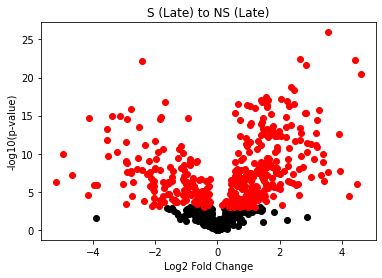

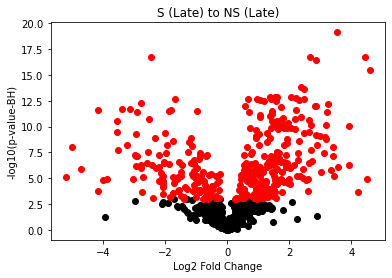

(11, 917)
(917,)
(917,)
(917,)
(917,)
(917,)
(917,)
(917,)
917
(917, 13)
       Metab       LFC    pvalue  p_adj     mean1    mean2      std1  \
0  100001632 -3.489476  0.007064    NaN  1.613964  0.14370  1.465060   
1  100015649 -0.795465  0.000684    NaN  1.213036  0.69890  0.268452   
2       1099 -0.362242  0.001073    NaN  1.132045  0.88068  0.165980   
3         73 -1.712609  0.006378    NaN  0.719745  0.21960  0.483791   
4        269 -0.504794  0.002113    NaN  0.939255  0.66195  0.127319   

           std2       SNR                           Metabolite  \
0  2.775558e-17 -1.003552                         formononetin   
1  2.848705e-01 -0.929180       isovaleryl/2-methylbutyryl CoA   
2  1.098504e-01 -0.911303                            guanosine   
3  8.721035e-02 -0.875909  cytidine 2',3'-cyclic monophosphate   
4  2.066848e-01 -0.830243                     CoA-glutathione*   

                                   SubPathway         HMDB PubchemID  
0                        F

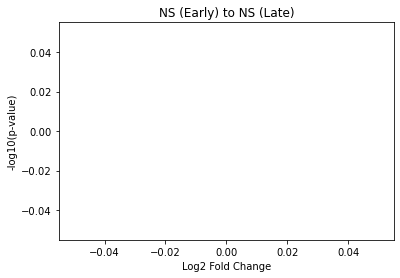

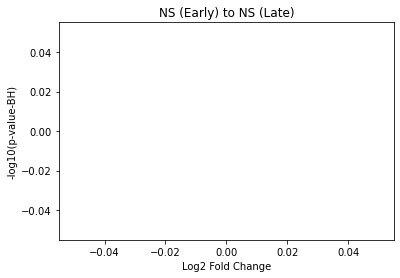

In [32]:
# Assemble list of comparisons

list_comparison = [('NS (Early)', 'S (Early)'), ('NS (Early)', 'S (Late)'),
                   ('NS (Late)', 'S (Early)'), ('NS (Late)', 'S (Late)'),
                   ('NS (Late)', 'NS (Early)')]
print(list_comparison)

cutoff_val = 0.05


for comp in list_comparison:
    group1 = comp[0]
    group2 = comp[1]
    idx1 = df_metab_PooledGeno.loc[df_metab_PooledGeno.Group==group1].index
    idx2 = df_metab_PooledGeno.loc[df_metab_PooledGeno.Group==group2].index
    
    # compute log-fold-change of the different metabolites
    df_analysis1 = df_metab_PooledGeno.iloc[idx1,1:]
    df_analysis2 = df_metab_PooledGeno.iloc[idx2,1:]
    print(df_analysis1.shape)
    mean_1 = np.mean(df_analysis1, axis=0)
    mean_2 = np.mean(df_analysis2, axis=0)
    std_1 = np.std(df_analysis1, axis=0)
    std_2 = np.std(df_analysis2, axis=0)
    LFC = np.log2(np.mean(df_analysis2, axis=0) / np.mean(df_analysis1, axis=0))
    SNR = (mean_2 - mean_1) / (std_1 + std_2)
    print(LFC.shape)
    print(SNR.shape)
    print(mean_1.shape)
    print(mean_2.shape)
    print(std_1.shape)
    print(std_2.shape)

    # compute p-values of the metabolites
    pVals = stats.ttest_ind(df_analysis1, df_analysis2, axis=0)[1]
    p_adj = multipletests(pvals=pVals, alpha=0.05, method="fdr_bh")
    print(pVals.shape)
    print(len(p_adj[1]))
    # assemble dataFrame and write to csv
    df_stats = pd.DataFrame(data={'Metab':df_metab_PooledGeno.iloc[:,1:].columns,'LFC':LFC, 
                                  'pvalue':pVals,'p_adj':p_adj[1],
                                 'mean1':mean_1,'mean2':mean_2,
                                  'std1':std_1,'std2':std_2,
                                 'SNR':SNR})
    df_stats=df_stats.reset_index(drop=True)
    
    # Add annotations and sort by SNR in descending
    df_stats = df_stats.reindex(df_stats.SNR.abs().sort_values(ascending=False).index).reset_index(drop=True)
    # write dictionary
    n = list()
    n2 = list()
    n3 = list()
    n4 = list()
    for i in range(df_stats.shape[0]):
        n.append(dict_chemID_to_metabolite[df_stats.Metab[i]])
        n2.append(dict_chemID_to_subPathway[df_stats.Metab[i]])
        n3.append(dict_chemID_to_HMDB[df_stats.Metab[i]])
        n4.append(dict_chemID_to_pubchem[df_stats.Metab[i]])
    df_stats['Metabolite'] = n
    df_stats['SubPathway'] = n2
    df_stats['HMDB'] = n3
    df_stats['PubchemID'] = n4
    # trim pubchem, hmdb to remove everything after delimiter
    df_stats['HMDB'] = df_stats['HMDB'].str.split(',').str[0]
    df_stats['PubchemID'] = df_stats['PubchemID'].str.split(';').str[0]

    print(df_stats.shape)
    print(df_stats.head())

    
    df_stats.to_csv('../processed/stats_pooledGeno_{}_to_{}.csv'.format(group2,group1))

    # print only the significant ones to csv
    df_stats_signif = df_stats[df_stats.pvalue <= cutoff_val]
    df_stats_signif.to_csv('../processed/stats_pooledGeno_signif_{}_to_{}.csv'.format(group2,group1))
    
    
    ##############################################################################
    # make volcano plots
    df_stats = df_stats.dropna(axis=0)
    idx_ns = df_stats.loc[df_stats.pvalue >= cutoff_val].index
    idx_sig = df_stats.loc[df_stats.pvalue < cutoff_val].index
    
    plt.figure()
    plt.title('{} to {}'.format(group2, group1))
    plt.xlabel('Log2 Fold Change')
    plt.ylabel('-log10(p-value)')
    plt.scatter(df_stats.loc[idx_ns,'LFC'], -np.log(df_stats.loc[idx_ns,'pvalue']),c='k')
    plt.scatter(df_stats.loc[idx_sig,'LFC'], -np.log(df_stats.loc[idx_sig,'pvalue']),c='r')
    plt.show()
    
    # make volcano plots with corrected p value
    df_stats = df_stats.dropna(axis=0)
    idx_ns = df_stats.loc[df_stats.p_adj >= cutoff_val].index
    idx_sig = df_stats.loc[df_stats.p_adj < cutoff_val].index
    
    plt.figure()
    plt.title('{} to {}'.format(group2, group1))
    plt.xlabel('Log2 Fold Change')
    plt.ylabel('-log10(p-value-BH)')
    plt.scatter(df_stats.loc[idx_ns,'LFC'], -np.log(df_stats.loc[idx_ns,'p_adj']),c='k')
    plt.scatter(df_stats.loc[idx_sig,'LFC'], -np.log(df_stats.loc[idx_sig,'p_adj']),c='r')
    plt.show()
    

# Try multiple models for classification

2020/07/07: Trying lazy package

In [22]:
import lazypredict
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split

C:\Users\Aditya\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [23]:
# Divide data into test_train
X = StandardScaler().fit_transform(df_metab_features_PooledGeno)
Y = df_metab_group_PooledGeno.str[1:]
print(Y.value_counts())

X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.3)
# X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2,
#                                                     random_state=30)

# Chose to stratify because of small number of LS_KO and ES_KO compared to rest

S_WT    27
H_WT    21
Name: Group, dtype: int64


In [24]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
print(models)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.95it/s]

                               Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                                                                          
LinearSVC                          1.00               1.00    None      1.00   
RidgeClassifierCV                  1.00               1.00    None      1.00   
PassiveAggressiveClassifier        1.00               1.00    None      1.00   
NuSVC                              1.00               1.00    None      1.00   
NearestCentroid                    1.00               1.00    None      1.00   
LogisticRegression                 1.00               1.00    None      1.00   
BaggingClassifier                  1.00               1.00    None      1.00   
LinearDiscriminantAnalysis         1.00               1.00    None      1.00   
RidgeClassifier                    1.00               1.00    None      1.00   
KNeighborsClassifier               1.00               1.00    None      1.00   
RandomForestClassifier             1.00 

## Characterize LinearSVC

In [25]:
from sklearn.svm import LinearSVC

In [26]:
clf = LinearSVC()
clf.fit(X_train,y_train)

LinearSVC()

In [27]:
df_metabFeatures_SVC = pd.DataFrame(data=clf.coef_[0],columns={'LinearSVC_coef'})
df_metabFeatures_SVC['metaboliteID'] = df_metab_features_PooledGeno.columns
df_metabFeatures_SVC['metabolite'] = df_metabFeatures_SVC['metaboliteID'].map(dict_chemID_to_metabolite)

In [28]:
df_metabFeatures_SVC=df_metabFeatures_SVC.reindex(df_metabFeatures_SVC.LinearSVC_coef.abs().sort_values(ascending=False).index)

In [29]:
df_metabFeatures_SVC.to_csv('../processed/pooledGeno_LinearSVC.csv')